In [93]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
def f(x):
    return 3*x**2 - 4*x + 5

In [95]:
f(3.0)

20.0

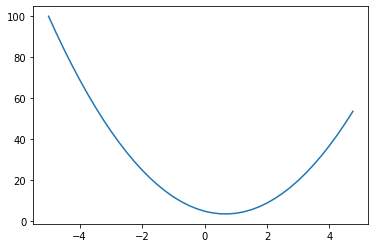

In [96]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
ys
plt.plot(xs, ys)

In [97]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [98]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [99]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c


print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [100]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

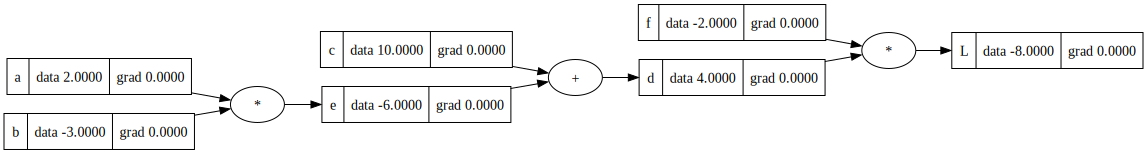

In [101]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

draw_dot(L)

In [ ]:
L = d * f 

In [102]:
L.grad = 1.0